In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

In [18]:
df = pd.read_csv('data/Consumption.csv')

The date input had inconsistent data, so the first step was to normalise the date format.

Dates were written in 3 different styles:
1. 01/01/2016
2. 20160101
3. 201611

As a first step to normalise the date, I took the 3rd format and transformed it to the second, where if the string contained 6 characters I introduced 0 in positions 5 and 7 -> 2016[0]1[0]1

If the date contained 7 characters, I introduced a 0 just in postion 5 -> 2016[0]116


Why don't I parse it directly to the dd/mm/yyyy format?

So after the previous step (introducing the zeroes) we will get problems for the last 3 months, Oct, Nov and Dec as for example:
2016111 could have meant both January 12 or November 2, but after introducing the zero in the previous step we turned it into 20160111. This this just happens with defined dates: 10 to 19 of Oct, Nov and Dec.

So my proces is, iterating through an **ordered** dataframe, and as soon as we find any of the following day-month dates '0101', '0111', '0121' (i.e. 2016**0111**), we check the preivous row, if the previous row is a day 30 or 31st, we replace the **0111** with **1101** as we now know this should actually be Nov 1st instead of Jan 11.

I've hardcoded these changes as they are punctual dates as stated above (oct-nov-dec 10 to 19)

In [19]:
def normalise_date(s):
    """
    Inserting 0s into the wrongly formatted dates (see above comment)
    """
    if len(s) == 6:
        return(f"{s[:4]}0{s[4]}0{s[5:]}")
    elif len(s) == 7:
        return(f"{s[:4]}0{s[4]}{s[5:]}")
    else:
        return(s)

In [20]:
def correcting_oct_nov_dec_dates(df):
    """
    As stated before here we overwrite oct-nov-dec 10 to 19 if we identify they are not january dates
    """
    index_positions = list(df[df['Date'].str[4:].isin(['0101', '0111', '0121'])].index)
    corrected_df = df.copy()
    for index in index_positions:
        if corrected_df.loc[index-1]['Date'][6:] == '31' or corrected_df.loc[index-1]['Date'][6:] == '30':
            year = corrected_df.loc[index-1]['Date'][:4]
            month = corrected_df.loc[index]['Date'][5:7]
            for i in range(9):
                corrected_df.at[index+i, 'Date'] = f"{year}{month}0{i+1}"
        else:
            continue
    return corrected_df

In [40]:
def parse_date(s):
    """
    Parsing date to the same final format
    """
    for fmt in ('%d/%m/%Y', '%Y%m%d'):
        try:
            return datetime.strptime(s, fmt)
        except ValueError:
            pass

In [45]:
def pivotting_df(df):
    #Extracting year from date
    df['Year'] = df['Date'].dt.year
    
    #Turnining the date into the requested format
    df['Month_Day'] = df['Date'].dt.strftime('%m-%d')
    df.drop(['Date'], axis = 1, inplace = True)
    df.set_index('Month_Day', inplace=True)
    
    #Pivotting table
    pivoted_df = df.pivot_table(index='Month_Day', columns='Year', values='Consumption')
    return (pivoted_df)

In [52]:
df['Date'] = df['Date'].apply(normalise_date)
corrected_date_df = correcting_oct_nov_dec_dates(df)

corrected_date_df['Date'] = corrected_date_df['Date'].apply(parse_date)

final_df = pivotting_df(corrected_date_df)

In [53]:
final_df.to_csv('outputs/q2.csv')

In [54]:
final_df

Year,2016,2017,2018,2019,2020,2021,2022
Month_Day,,,,,,,
01-01,276.2910,339.5196,305.9370,313.6320,344.9952,344.0718,246.6612
01-02,294.6780,405.7614,365.8932,391.3758,380.8296,362.9772,263.8980
01-03,306.3096,407.3976,368.2746,424.1646,356.8698,365.1480,316.3698
01-04,370.0566,419.0454,372.1140,404.0766,348.2028,436.0716,348.6078
01-05,367.3998,457.1640,367.8534,364.0140,357.5502,446.6340,360.4338
...,...,...,...,...,...,...,...
12-27,329.5728,347.8140,358.4736,337.5432,320.3550,330.2694,NaN
12-28,352.5606,357.4044,356.5296,343.2780,363.7872,311.3802,NaN
12-29,365.2614,351.6534,330.2370,338.0292,365.9094,299.7648,NaN


### Plotting

The describe method will give us most of the data we need (average, max and mins)

In [56]:
yearly_stats = final_df.describe()

In [60]:
mask_non_leap_year = np.isfinite(final_df[2021].to_numpy())
mask_2022 = np.isfinite(final_df[2022].to_numpy())

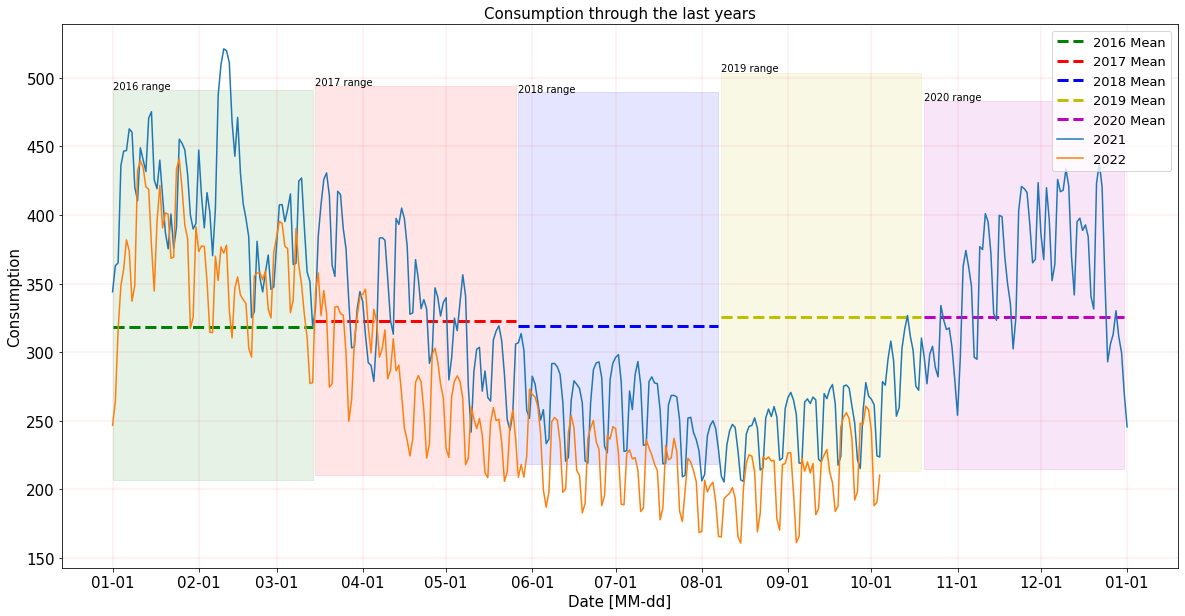

In [131]:
fig, ax = plt.subplots(figsize=(20, 10))


ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt='%m-%d'))
ax.tick_params(axis='both', which='major', labelsize=15)


# Plot the average lines
ax.plot(final_df.index[0:73], [yearly_stats[2016]['mean']]*73, \
        label='2016 Mean', linestyle='--', linewidth = 3, c='g')
# Plot max min and shading
ax.fill_between(final_df.index[0:73], [yearly_stats[2016]['max']]*73,\
                [yearly_stats[2016]['min']]*73, alpha=0.1, color='g')
ax.text(0,492, '2016 range', fontsize=10)

# Plot the average lines
ax.plot(final_df.index[73:146], [yearly_stats[2017]['mean']]*73, \
        label='2017 Mean', linestyle='--', linewidth = 3, c='r')
# Plot max min and shading
ax.fill_between(final_df.index[73:146], [yearly_stats[2017]['max']]*73,\
                [yearly_stats[2017]['min']]*73, alpha=0.1, color='r')
ax.text(73,495, '2017 range', fontsize=10)

# Plot the average lines
ax.plot(final_df.index[146:219], [yearly_stats[2018]['mean']]*73, \
        label='2018 Mean', linestyle='--', linewidth = 3, c='b')
# Plot max min and shading
ax.fill_between(final_df.index[146:219], [yearly_stats[2018]['max']]*73,\
                [yearly_stats[2018]['min']]*73, alpha=0.1, color='b')
ax.text(146,490, '2018 range', fontsize=10)

# Plot the average lines
ax.plot(final_df.index[219:292], [yearly_stats[2019]['mean']]*73, \
        label='2019 Mean', linestyle='--', linewidth = 3, c='y')
# Plot max min and shading
ax.fill_between(final_df.index[219:292], [yearly_stats[2019]['max']]*73,\
                [yearly_stats[2019]['min']]*73, alpha=0.1, color='y')
ax.text(219,505, '2019 range', fontsize=10)

# Plot the average lines
ax.plot(final_df.index[292:365], [yearly_stats[2020]['mean']]*73, \
        label='2020 Mean', linestyle='--', linewidth = 3, c='m')
# Plot max min and shading
ax.fill_between(final_df.index[292:365], [yearly_stats[2020]['max']]*73,\
                [yearly_stats[2020]['min']]*73, alpha=0.1, color='m')
ax.text(292,484, '2020 range', fontsize=10)



ax.plot(final_df.index[mask_non_leap_year], final_df[2021].to_numpy()[mask_non_leap_year], label='2021')
ax.plot(final_df.index[mask_non_leap_year], final_df[2022].to_numpy()[mask_non_leap_year], label='2022')


ax.grid(color='r', linestyle='-', linewidth=0.1)

plt.title("Consumption through the last years", fontsize=15)
plt.xlabel("Date [MM-dd]", fontsize=15)
plt.ylabel("Consumption", fontsize=15)

# Make a legend
legend = ax.legend(loc='upper right', prop={'size': 13})

Decided to split the yearly average and ranges for 2016-2020 through the plot as everything on top of everything looked too cluttered.

The trends of the plot lead me to guess its a commodity related to heating, so gas or power(?), as consumption lowers a lot during summer months and spikes in winter.

There seems to be a big outlier in the fist half of february 2021, it is a long shot to guess where exactly is this consumption data from, but looking at historic weather data from the UK, London for example, consistently hit negative temperatures, going to to even -5 degreesC between Febraury 10-13th 2021.

The decrease in consumption (by a lot) during summer 2022 gives me another hint this consumption data relates to the UK (or somewhere else close in Europe), as the UK hit its hottest and driest summer in history last year.